In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 0. Data Exploration

In [29]:
from datetime import datetime
dateparser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')
df = pd.read_csv("KPIs sample 5 cells data_train.csv",
                 delimiter=";",
                 parse_dates=['index'],
                 date_parser=dateparser,
                 index_col="index"
                 )
df.head()

,cell_id,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,PDCP_SDU_Volume_DL,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,Intra_eNB_HO_SR_total_RATIO,E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO,...,E_RAB_QCI1_DR_RATIO,DCR_LTE_RATIO,CSSR_LTE_RATIO,LTE_INTER_ENODEB_HOSR_RATIO,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,Inter_RAT_Total_HO_SR_RATIO,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,DL_THROUGHPUT_RATIO,E_RAB_DR_RATIO
index,,,,,,,,,,,,,,,,,,,,,
2021-05-09 00:00:00,2.226537e+17,3.779737e+10,3.947172e+09,15.0,3.779737e+10,4727.0,0.809859,0.992427,0.809859,0.007665,...,0.000000,0.001761,0.996041,0.400000,0.770642,0.963636,0.963636,0.400000,82.550417,0.001761
2021-05-09 01:00:00,2.226537e+17,3.684898e+10,4.088752e+09,6.0,3.684898e+10,3076.0,0.886792,0.993288,0.886792,0.006712,...,0.000000,0.002468,0.995465,0.500000,0.842105,1.000000,1.000000,0.500000,80.531811,0.002468
2021-05-09 02:00:00,2.226537e+17,3.292677e+10,5.016897e+09,8.0,3.292677e+10,3501.0,0.938356,0.994664,0.938356,0.005336,...,0.013889,0.003077,0.996044,0.375000,0.931624,1.000000,0.966667,0.375000,71.885311,0.003077
2021-05-09 03:00:00,2.226537e+17,3.021547e+10,5.139107e+09,9.0,3.021547e+10,2275.0,0.860215,0.994819,0.860215,0.005181,...,0.000000,0.001721,0.995920,0.777778,0.816901,0.947368,0.947368,0.777778,65.977430,0.001721
2021-05-09 04:00:00,2.226537e+17,3.082176e+10,4.250716e+09,17.0,3.082176e+10,2178.0,0.840426,0.995952,0.840426,0.004048,...,0.000000,0.002213,0.995628,0.764706,0.794521,1.000000,1.000000,0.764706,67.324805,0.002213


In [3]:
# Check the number of records
len(df)

8280

In [15]:
# Check cell_id count
df["cell_id"].value_counts()

9.106218e+16    1656
2.226537e+17    1656
3.844733e+17    1656
4.262775e+17    1656
7.315874e+16    1656
Name: cell_id, dtype: int64

## 0.1 Check null value 

In [10]:
def chechNull(df):
    print(df.isnull().sum(axis=0))

chechNull(df)

index                                                         0
cell_id                                                       0
DL_TRAFFIC_VOLUME                                            21
UL_TRAFFIC_VOLUME                                            21
Inter_X2_based_HO_prep                                     3313
PDCP_SDU_Volume_DL                                         3313
VoLTE_total_traffic                                        3313
INTRA_FREQ_HO_SR_RATIO                                       40
RRC_SR_RATIO                                                 28
Intra_eNB_HO_SR_total_RATIO                                3321
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO    3313
CELL_AVAILABILITY_RATIO                                      20
RACH_Stp_Completion_SR_RATIO                               3313
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                        3313
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          5595
UL_THROUGHPUT_RATIO                     

## 0.2 Check infinite values

In [61]:
def checkInfinite(df):
    # print out infinite value counts
    print("n_infinite \t feature_name")
    for feature in df.columns: 
        n_inf = np.isinf(df[feature]).sum()
        print(str(n_inf) + "\t\t" +feature)

        
# remove "index" and "cell_id"        
checkInfinite(df)

n_infinite 	 feature_name
0		cell_id
0		DL_TRAFFIC_VOLUME
0		UL_TRAFFIC_VOLUME
0		Inter_X2_based_HO_prep
0		PDCP_SDU_Volume_DL
0		VoLTE_total_traffic
0		INTRA_FREQ_HO_SR_RATIO
0		RRC_SR_RATIO
0		Intra_eNB_HO_SR_total_RATIO
0		E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO
0		CELL_AVAILABILITY_RATIO
0		RACH_Stp_Completion_SR_RATIO
0		Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO
1		Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO
0		UL_THROUGHPUT_RATIO
0		E_RAB_QCI1_DR_RATIO
0		DCR_LTE_RATIO
0		CSSR_LTE_RATIO
0		LTE_INTER_ENODEB_HOSR_RATIO
0		E_UTRAN_Inter_Freq_HO_SR_RATIO
0		Inter_RAT_HO_SR_GERAN_SRVCC_RATIO
0		Inter_RAT_Total_HO_SR_RATIO
0		E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO
0		DL_THROUGHPUT_RATIO
0		E_RAB_DR_RATIO


In [64]:
# drop inf 
condition = df["Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO"]==np.inf
df = df.drop(df[condition].index)

**Plot the distribution of each feature**

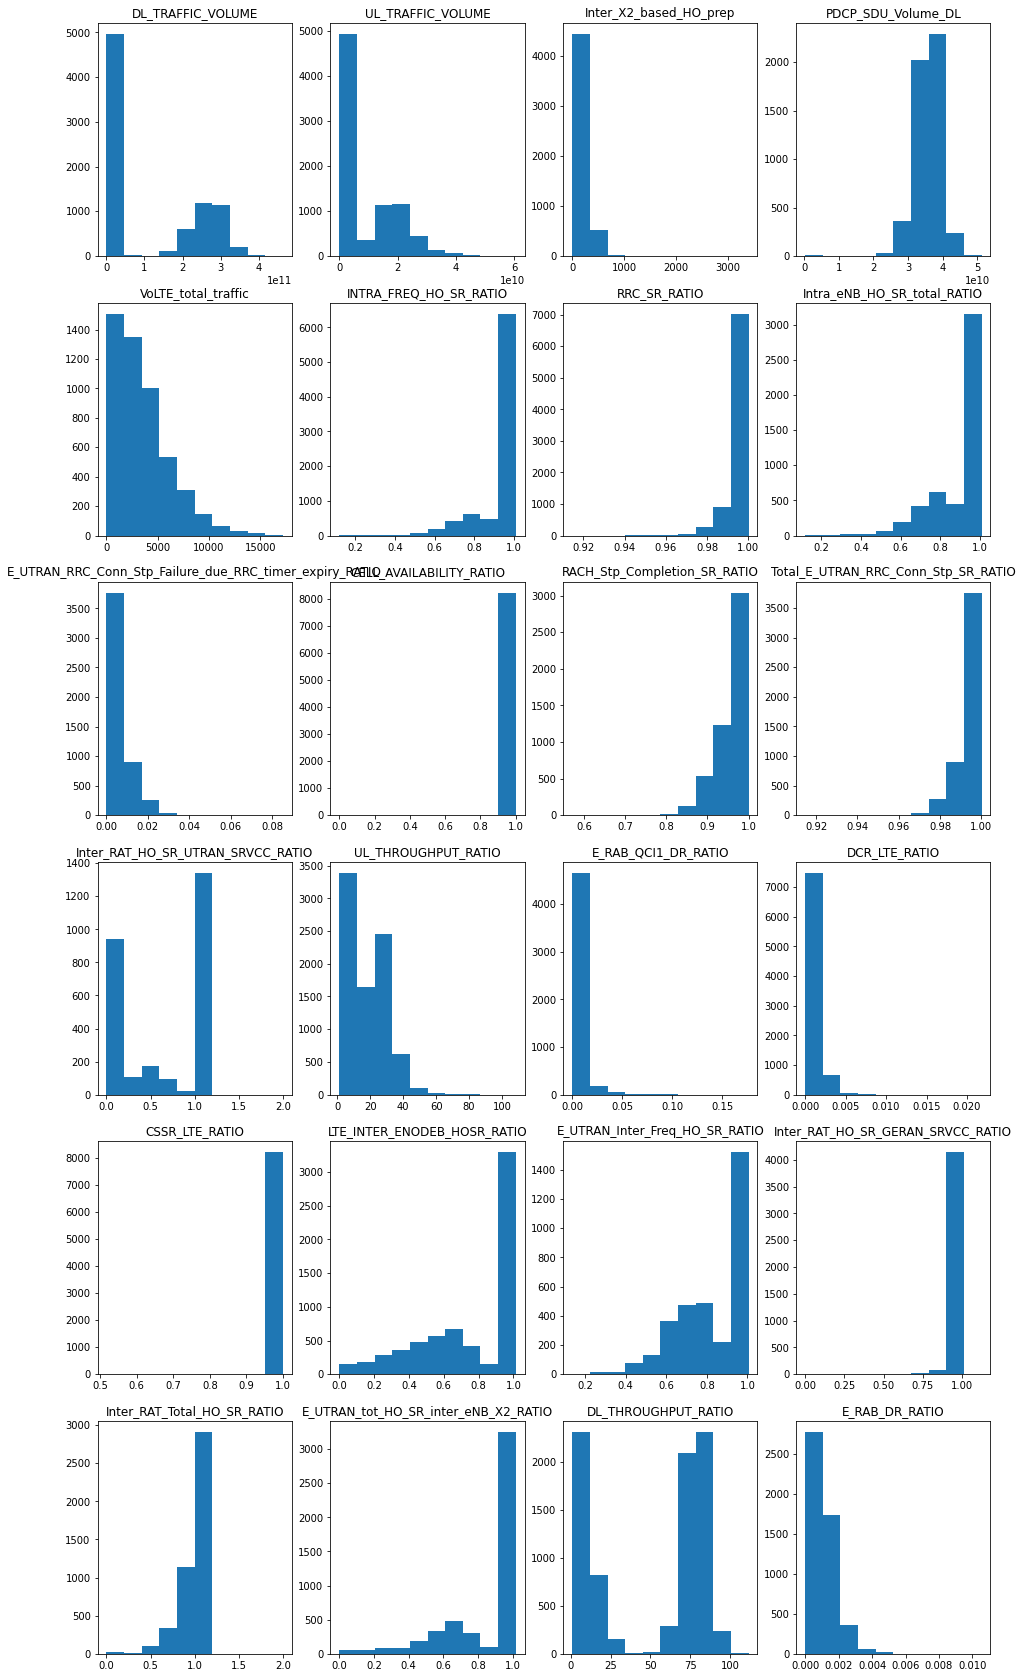

In [65]:
import math 

def showFeatureDistribution(df_features):
    """
    Input
    @df_features: a dataframe that contains the features to explore 
    
    """
    feature_names = df_features.columns
    feature_nb = len(feature_names)

    # plot the distribution of each feature
    n_per_row = 4
    n_rows = math.ceil(feature_nb/n_per_row)

    def get_fig_position(i,n_per_row):
        row = i/n_per_row
        col = i%n_per_row
        return int(row),int(col)

    # plot hist
    fig,ax = plt.subplots(n_rows,n_per_row,figsize=[4*n_per_row,5*n_rows])
    for i,name in enumerate(feature_names):
        ix,iy = get_fig_position(i,n_per_row)
        axes = ax[ix][iy]
        feature = df_features[name].dropna()
        axes.set_title(name)
        axes.hist(feature)
    plt.show()

showFeatureDistribution(df.drop(["cell_id"],axis=1))

## 0.3 Seperated Cells

In [67]:
cell_ids = df["cell_id"].unique()

df_cells = []
for i in range(len(cell_ids)):
    cell_id = cell_ids[i]
    df_cells.append(df[df["cell_id"]==cell_id])

In [68]:
for i in range(len(cell_ids)):
    df_cell = df_cells[i].drop("cell_id",axis=1)
    print("="*60)
    print(f"CELL ID: {cell_ids[i]}")
    print(f"Number Of Data: {len(df_cell)}")
    print(df_cell.isnull().sum(axis=0))
    print()

CELL ID: 2.2265366483183206e+17
Number Of Data: 1655
DL_TRAFFIC_VOLUME                                            1
UL_TRAFFIC_VOLUME                                            1
Inter_X2_based_HO_prep                                       1
PDCP_SDU_Volume_DL                                           1
VoLTE_total_traffic                                          1
INTRA_FREQ_HO_SR_RATIO                                       1
RRC_SR_RATIO                                                 1
Intra_eNB_HO_SR_total_RATIO                                  1
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO      1
CELL_AVAILABILITY_RATIO                                      1
RACH_Stp_Completion_SR_RATIO                                 1
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                          1
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          931
UL_THROUGHPUT_RATIO                                          1
E_RAB_QCI1_DR_RATIO                                          1
DC

# 1. Data preprocessing

## 1.1 Null values

Fill nan values by using interpolation

Modeling test

In [ ]:
model=IsolationForest(n_estimators=50, 
                      max_samples ='auto', 
                      max_features=1.0)
model.fit(df_cell1)